### In this notebook, we are going to pre-process and encode the data with Bag of Words and Fasttext representations.

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import copy
import io
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from collections import Counter

## Data Imports

In [2]:
data1 = pickle.load(open('BIOS.pkl','rb'))
data2 = pickle.load(open('BIOS2.pkl','rb'))
data3 = pickle.load(open('BIOS3.pkl','rb'))
data4 = pickle.load(open('BIOS4.pkl','rb'))
#data5 = pickle.load(open('BIOS5.pkl','rb'))

In [3]:
data = data1 + data2 + data3 + data4

In [4]:
len(data)

27325

Each data is associated with a person and has 3 parts: a small biography of the person, the person's job (title) ans the person's gender.

In [5]:
X_raw = ['' for i in range(len(data))]
Titles = ['' for i in range(len(data))]
Gen = ['' for i in range(len(data))]

for i in range(len(data)):
    X_raw[i] = data[i]["raw"][data[i]["start_pos"]:]
    Titles[i] = data[i]["title"]
    Gen[i] = data[i]["gender"]

In X_raw we have the raw biographies:

In [6]:
X_raw[:5]

[' He has the UK’s #1 rated health and fitness podcast on iTunes ‘Ben Coomber Radio’. Ben also run’s The BTN Academy, an online nutrition education company and he owns Awesome Supplements, a brand offering clarity in the confusing world of supplements.',
 ' She enjoys indoor cycling and yoga, a good glass of red wine with friends, and of course anything to do with being in the kitchen! Subscribe by email for updates, and be sure to follow her on Instagram, Twitter, Facebook and Pinterest for more recipe inspiration!',
 ' With influences and themes ranging from Buddhism and haiku to Modernism and the Romantics, Gray inhabits a landscape at once spare and elaborate, ritualistic and impulsive.',
 ' Stuart has extensive experience with causal inference in randomized trials and non-experimental studies, with particular interests in the trade-offs of different study designs. Her research focuses on two areas: 1) propensity score methods for estimating causal effects in non-experimental studi

In Titles we have the professions, look at the set of professions represented in this dataset:

In [7]:
set(Titles)

{'accountant',
 'acupuncturist',
 'architect',
 'attorney',
 'chiropractor',
 'comedian',
 'composer',
 'dentist',
 'dietitian',
 'dj',
 'filmmaker',
 'interior_designer',
 'journalist',
 'landscape_architect',
 'magician',
 'massage_therapist',
 'model',
 'nurse',
 'painter',
 'paralegal',
 'pastor',
 'personal_trainer',
 'photographer',
 'physician',
 'poet',
 'professor',
 'psychologist',
 'rapper',
 'real_estate_broker',
 'software_engineer',
 'surgeon',
 'teacher',
 'yoga_teacher'}

The repartition is as follow: 

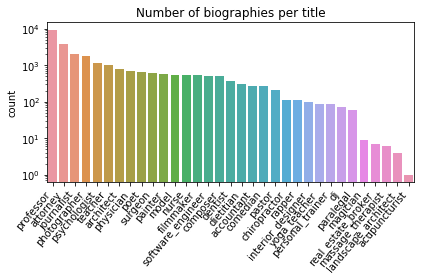

In [8]:
ax = sns.countplot(Titles, order = [Counter(Titles).most_common()[i][0] for i in range(len(set(Titles)))])
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
ax.set(yscale="log")
plt.title('Number of biographies per title')
plt.tight_layout()
plt.show()

In order to have a dataset balanced in terms of gender, the majority of the jobs represented are gender balanced. Still, a few job like software engineer tend to be unbalanced. 

In Gen, we have the gender information. In our dataset, Male/Female repartition is like this:

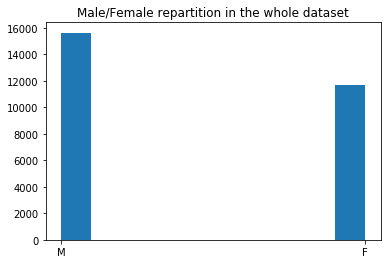

In [9]:
plt.hist(Gen)
plt.title('Male/Female repartition in the whole dataset')
plt.show()

Proportion of female per title:

In [10]:
title_prop = {}
for title in set(Titles):
    ct = 0
    cf = 0
    lt = len(Titles)
    for i in range(lt):
        if Titles[i]==title:
            if Gen[i]=='F':
                cf+=1
            ct+=1
    title_prop[title] = cf/ct

In [11]:
pickle.dump(title_prop, open("title_prop.pkl","wb"))

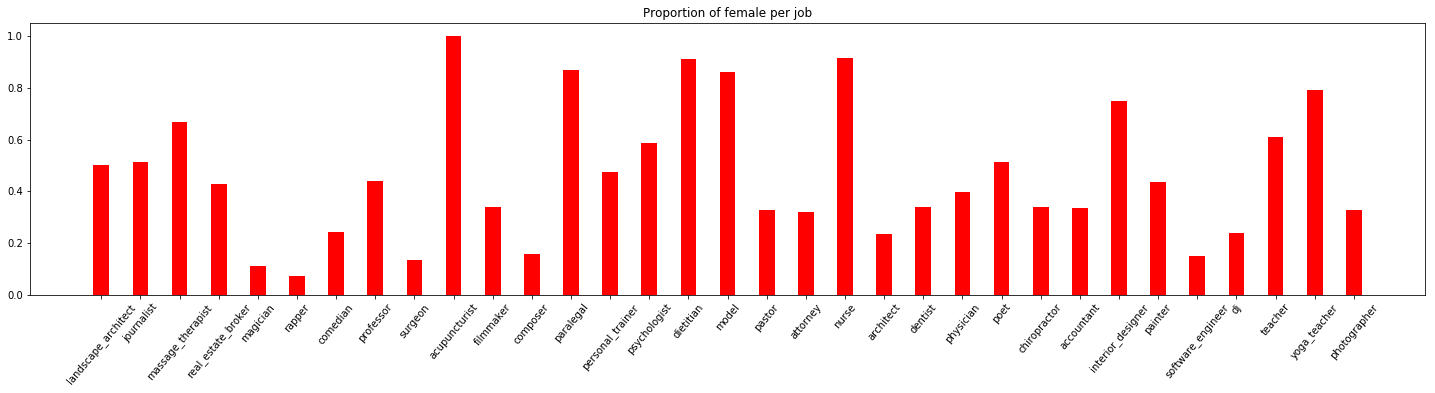

In [12]:
plt.figure(figsize=(25,5))
plt.bar(title_prop.keys(), title_prop.values(), width=.4, color='r')
plt.title('Proportion of female per job')
plt.xticks(rotation=50)
plt.show()

We can see that female/male repartitions tend to vary depending on the title.
Later we will try to correlate it with the TPR of our models.

## Gender informations removal

We are now going to build a dataset without gender information.

In [13]:
def tokenize(X_raw):
    X_tok = []
    for i in range(len(X_raw)):
        X_tok = X_tok + [word_tokenize(X_raw[i])]   
    return X_tok

def untokenize(X_tok):
    l = len(X_tok)
    X_raw = ['' for c in range(l)]
    for i in range(l):
        li = len(X_tok[i])
        for j in range(li):
            X_raw[i] = X_raw[i] + ' ' + X_tok[i][j]
    return X_raw

In [14]:
X_tok = tokenize(X_raw)

Find max length line:

In [27]:
mx = 0
for i in range(len(X_tok)):
    if len(X_tok[i])>mx:
        mx = len(X_tok[i])
print(mx)

197


In [15]:
def remove_gender_info(X_tok):
    ans = copy.deepcopy(X_tok)
    gen = ['He','She','he','she','Her','His','her','his','Him','him','Hers','hers',
           'Himself','himself','Herself','herself','Mr','mr','Ms','ms','mrs','wife',
           'husband','women', 'feminist','girl','woman','men','man','boy']
    lx = len(ans)
    for i in range(lx):
        lxi = len(ans[i])
        bio = ans[i]
        j=0
        while j<lxi:
            if bio[j] in gen:
                del ans[i][j]
                lxi-=1
                j-=1
            j+=1
    return ans

In [16]:
X_tok_nogen = remove_gender_info(X_tok)

In [17]:
X_nogen = untokenize(X_tok_nogen)

X_nogen is a corpus of biographies without pronouns. Assuming that men and women are described in the same way in the biographies, the pronouns should contain all the gender informations. Therefore, removing them would imply removing all the gender informations. 

In [18]:
X_nogen[:5]

[' has the UK ’ s # 1 rated health and fitness podcast on iTunes ‘ Ben Coomber Radio ’ . Ben also run ’ s The BTN Academy , an online nutrition education company and owns Awesome Supplements , a brand offering clarity in the confusing world of supplements .',
 ' enjoys indoor cycling and yoga , a good glass of red wine with friends , and of course anything to do with being in the kitchen ! Subscribe by email for updates , and be sure to follow on Instagram , Twitter , Facebook and Pinterest for more recipe inspiration !',
 ' With influences and themes ranging from Buddhism and haiku to Modernism and the Romantics , Gray inhabits a landscape at once spare and elaborate , ritualistic and impulsive .',
 ' Stuart has extensive experience with causal inference in randomized trials and non-experimental studies , with particular interests in the trade-offs of different study designs . research focuses on two areas : 1 ) propensity score methods for estimating causal effects in non-experimenta

### Titles and Gender datasets

In [19]:
df_titles = pd.DataFrame(Titles)

In [20]:
pickle.dump(df_titles, open("Titles.pkl","wb"))

In [21]:
df_gen = pd.DataFrame(Gen)

In [22]:
pickle.dump(df_gen, open("Gen.pkl","wb"))

## Bag of words

We then encode the biographies with Bag of Words representations. This can easily be done with scikit learn's CountVectorizer. 

In [19]:
vectorizer = CountVectorizer()

X_bw = vectorizer.fit_transform(X_raw).toarray()
X_bw_nogen = vectorizer.transform(X_nogen).toarray()

In [20]:
def convert_to_sparse_pandas(df):
    """
    Converts columns of a data frame into SparseArrays and returns the data frame with transformed columns.
    """
    df = df.copy()

    for (columnName, columnData) in df.iteritems():
        df[columnName] = pd.SparseArray(columnData.values, dtype='uint8')
    return df

In [21]:
df_X_bw = pd.DataFrame(data=X_bw, columns=vectorizer.get_feature_names(), dtype=np.int8)
df_X_bw_nogen = pd.DataFrame(data=X_bw_nogen, columns=vectorizer.get_feature_names(), dtype=np.int8)

In [22]:
pickle.dump(df_X_bw, open("X_bw.pkl","wb"))
pickle.dump(df_X_bw_nogen, open("X_bw_nogen.pkl","wb"))

# Fastext

We are now going to use Facebook's Fasttext word embeddings.

Fasttext encodings require a lot of data to be trained efficiently and we did not have enough data nor the computational power to produce meaningful embeddings.
So we downloaded a model trained on wikiepdia articles.

In [31]:
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data

In [32]:
embeds = load_vectors('fasttext_emb.vec')

The function fasttext_vocab will enable us to build a dictionnary associating each word of our corpus with its fasttext embedding. 

In [33]:
def fasttext_vocab(vectorizer, embeds):
    vocab = vectorizer.get_feature_names()
    ft_vocab = {}
    lv = len(vocab)
    compt = 0
    while compt<lv:
        voc = vocab[compt]
        if voc in embeds.keys():
            ft_vocab[voc] = [np.fromiter(embeds[voc], dtype=np.float64)]
        compt+=1
    return ft_vocab

In [34]:
ft_vocab = fasttext_vocab(vectorizer, embeds)

### Biography encoding

Then, we build a dataset of biographies, where each biography is encoded with the mean of all the embeddings of its words:

In [35]:
def fasttext_bio_vec(X_raw, ft_vocab):
    X = tokenize(X_raw)
    lx = len(X)
    #Fasttext word embeddings are vectors of size 300
    ans = [[0 for i in range(300)] for j in range(lx)]
    for i in range(lx):
        ansi = np.array([0 for i in range(300)])
        compti = 0
        for word in X[i]:
            if word in ft_vocab.keys():
                ansi = ansi + ft_vocab[word][0]
                compti+=1
        ans[i] = ansi/compti
    return ans

In [36]:
def fasttext_bio_ind(X_raw, ft_vocab):
    X = tokenize(X_raw)
    lx = len(X)
    #Fasttext word embeddings are vectors of size 300
    ans = [[[0 for i in range(300)] for z in range(197)] for j in range(lx)]
    for i in range(lx):
        compti = 0
        for word in X[i]:
            if word in ft_vocab.keys():
                ans[i][compti] = [ft_vocab[word]]
                compti+=1
    return ans

In [26]:
X_fasttext = fasttext_bio_vec(X_raw, ft_vocab)

In [27]:
X_fasttext_nogen = fasttext_bio_vec(X_nogen, ft_vocab)

In [28]:
df_X_fasttext = pd.DataFrame(X_fasttext)
df_X_fasttext_nogen = pd.DataFrame(X_fasttext_nogen)

In [29]:
pickle.dump(df_X_fasttext, open("X_fasttext.pkl","wb"))
pickle.dump(df_X_fasttext_nogen, open("X_fasttext_nogen.pkl","wb"))